# Demonstration of the QLSAs workflow, following the qiskit patterns framework

In [7]:
# Set system path

from pathlib import Path
import sys


def find_repo_root(start: Path | None = None) -> Path:
    p = (start or Path.cwd()).resolve()
    for d in (p, *p.parents):
        if (d / ".git").exists() or (d / "pyproject.toml").exists() or (d / "src").exists():
            return d
    return p  # fallback


repo_root = find_repo_root()
print(repo_root)

# This repo uses a "src layout" (the Python package lives in <repo>/src/qlsas),
# but the repo is not installed as a package. Add <repo>/src to sys.path.
src_dir = repo_root / "src"
if src_dir.exists() and str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

# Also add the repo root so you can import top-level modules like
# `linear_systems_problems.random_matrix_generator`.
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

/Users/adrianharkness/QCOL_COPT/HHL/QLSAs


In [8]:
# Import QLSAs modules

from qlsas.qlsa.hhl.hhl import HHL
from qlsas.data_loader import StatePrep
from qlsas.transpiler import Transpiler
from qlsas.executer import Executer
from qlsas.post_processor import Post_Processor
from qlsas.solver import QuantumLinearSolver
from qlsas.refiner import Refiner
from linear_systems_problems.random_matrix_generator import generate_problem

# Import other modules
from datetime import datetime
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

%config InlineBackend.figure_format = "retina"

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
})

## Step 0: **Define** the (classical) problem

In [9]:
n = 64
prob = generate_problem(n=n, cond_number=5.0, sparsity=0.5, seed=0)
A, b = prob["A"], prob["b"]

A  = A / np.linalg.norm(b)
b = b / np.linalg.norm(b)

print(f"A: {A}")
print()
print(f"b: {b}")
print()
print(f"sorted eigenvalues: {sorted(np.linalg.eigvalsh(A))}")

A: [[ 2.91926641e-01 -3.38136189e-17 -2.88642347e-17 ... -8.60839284e-03
   1.51035121e-16  6.24196248e-17]
 [-3.38136189e-17  2.93048408e-01 -1.50638611e-02 ... -1.06461971e-16
  -5.82269385e-03  1.85721242e-02]
 [-2.88642347e-17 -1.50638611e-02  4.16613329e-01 ...  3.15612904e-18
   2.76855907e-02 -9.27387386e-03]
 ...
 [-8.60839284e-03 -1.06461971e-16  3.15612904e-18 ...  3.63137728e-01
  -8.35513434e-17  9.58315546e-18]
 [ 1.51035121e-16 -5.82269385e-03  2.76855907e-02 ... -8.35513434e-17
   5.51148310e-01 -8.76857090e-03]
 [ 6.24196248e-17  1.85721242e-02 -9.27387386e-03 ...  9.58315546e-18
  -8.76857090e-03  2.55006783e-01]]

b: [-0.06555726  0.02541242 -0.01966206  0.15028181 -0.087905    0.00116195
 -0.05801744  0.14178475 -0.13946446  0.14421469  0.03032722  0.25233556
  0.21360835  0.02527191 -0.00582985  0.04729965 -0.19712973  0.04020203
 -0.12655581 -0.08790688 -0.0045977  -0.05154528 -0.01022726  0.06747633
  0.10198877 -0.15606097 -0.04079102  0.15665257  0.02294012  0.3

## Step 1: **Map** problem to quantum circuits and operators

In [10]:
hhl = HHL(
    state_prep = StatePrep(method='default'),
    readout = 'measure_x', # 'measure_x' or 'swap_test'
    num_qpe_qubits = int(math.log2(len(b))),
    eig_oracle = "classical" # "classical" or "quantum"
)

In [11]:
hhl_circuit = hhl.build_circuit(A, b) # swap_test_vector = np.ones(len(b)) / np.linalg.norm(np.ones(len(b)))
hhl_circuit.draw(output='mpl', fold=-1)

## Step 2: **Optimize** for target hardware

In [12]:
service = QiskitRuntimeService(name="QLSAs")
service.backends()

[<IBMBackend('ibm_fez')>,
 <IBMBackend('ibm_pittsburgh')>,
 <IBMBackend('ibm_boston')>,
 <IBMBackend('ibm_miami')>,
 <IBMBackend('ibm_torino')>,
 <IBMBackend('ibm_marrakesh')>,
 <IBMBackend('ibm_kingston')>]

In [13]:
# Define a backend

# use a specific hardware backend
# backend = service.backend("ibm_boston")

# or use the least busy backend
# backend = service.least_busy(operational=True, min_num_qubits=hhl_circuit.num_qubits)
# print("Backend: ", backend)

# or use a simulator
# noiseless:
backend = AerSimulator()

# noisy:
# Add depolarizing error to all single qubit u1, u2, u3 gates
# noise_model = NoiseModel()
# error_prob = .05
# error = depolarizing_error(error_prob, 1)
# noise_model.add_all_qubit_quantum_error(error, ["u1", "u2", "u3"])
# backend = AerSimulator(noise_model=noise_model)

In [14]:
# Transpile the circuit

transpiler = Transpiler(circuit=hhl_circuit, backend=backend, optimization_level=3)
transpiled_hhl_circuit = transpiler.optimize()

print(f"2q-depth:        {transpiled_hhl_circuit.depth(lambda x: x.operation.num_qubits==2)}")
print(f"2q-size:         {transpiled_hhl_circuit.size(lambda x: x.operation.num_qubits==2)}")
print(f"Operator counts: {transpiled_hhl_circuit.count_ops()}")

2q-depth:        39854
2q-size:         41446
Operator counts: OrderedDict([('ccx', 21396), ('cu', 18456), ('crz', 17279), ('cx', 5681), ('u2', 4106), ('p', 3286), ('u3', 407), ('cp', 30), ('h', 24), ('barrier', 9), ('x', 8), ('measure', 7), ('u1', 5)])


## Step 3: **Execute** on target hardware

In [15]:
executer = Executer()

result = executer.run(
    transpiled_circuit = transpiled_hhl_circuit, 
    backend = backend,
    shots = 1000
    )

>>> Job ID: b48e8c4c-fe8b-4804-97b0-7ee840cd90fd
>>> Job Status: DONE      


## Step 4: **Process** result to obtain classical solution

In [16]:
processor = Post_Processor()
solution, success_rate, residual = processor.process_tomography(result, A, b)

total shots: 1000
num_successful_shots: 131
success rate: 0.131
solver residual: 0.43967104076341124


## Wrapping steps 1-4 together in a solver:

In [17]:
hhl_solver = QuantumLinearSolver(
    qlsa = hhl,
    backend = backend,
    target_successful_shots = 1000,
    shots_per_batch = 100000,
    optimization_level = 3,
    executer = executer,
    post_processor = processor,)
    #mode = "session")

## Integrate **Iterative Refinement** to improve accuracy

IR Iteration: 0
>>> Job ID: ef86542f-1e09-49b8-83d6-8a78371a8c9a
>>> Job Status: DONE      
  residual: 0.2083, error: 0.1595, alpha: 2.8070

IR Iteration: 1
>>> Job ID: b1d96373-282c-4300-a3db-c680475e7f79
>>> Job Status: DONE      
  residual: 0.0311, error: 0.0244, alpha: 0.9753

IR Iteration: 2
>>> Job ID: db458b89-eef2-4838-ad61-8a6e692e51d2
>>> Job Status: DONE      
  residual: 0.0048, error: 0.0035, alpha: 0.2851

IR Iteration: 3
>>> Job ID: 43b640af-e061-43d6-aecb-ab4a2f5ff3fd
>>> Job Status: DONE      
  residual: 0.0006, error: 0.0005, alpha: 0.0872



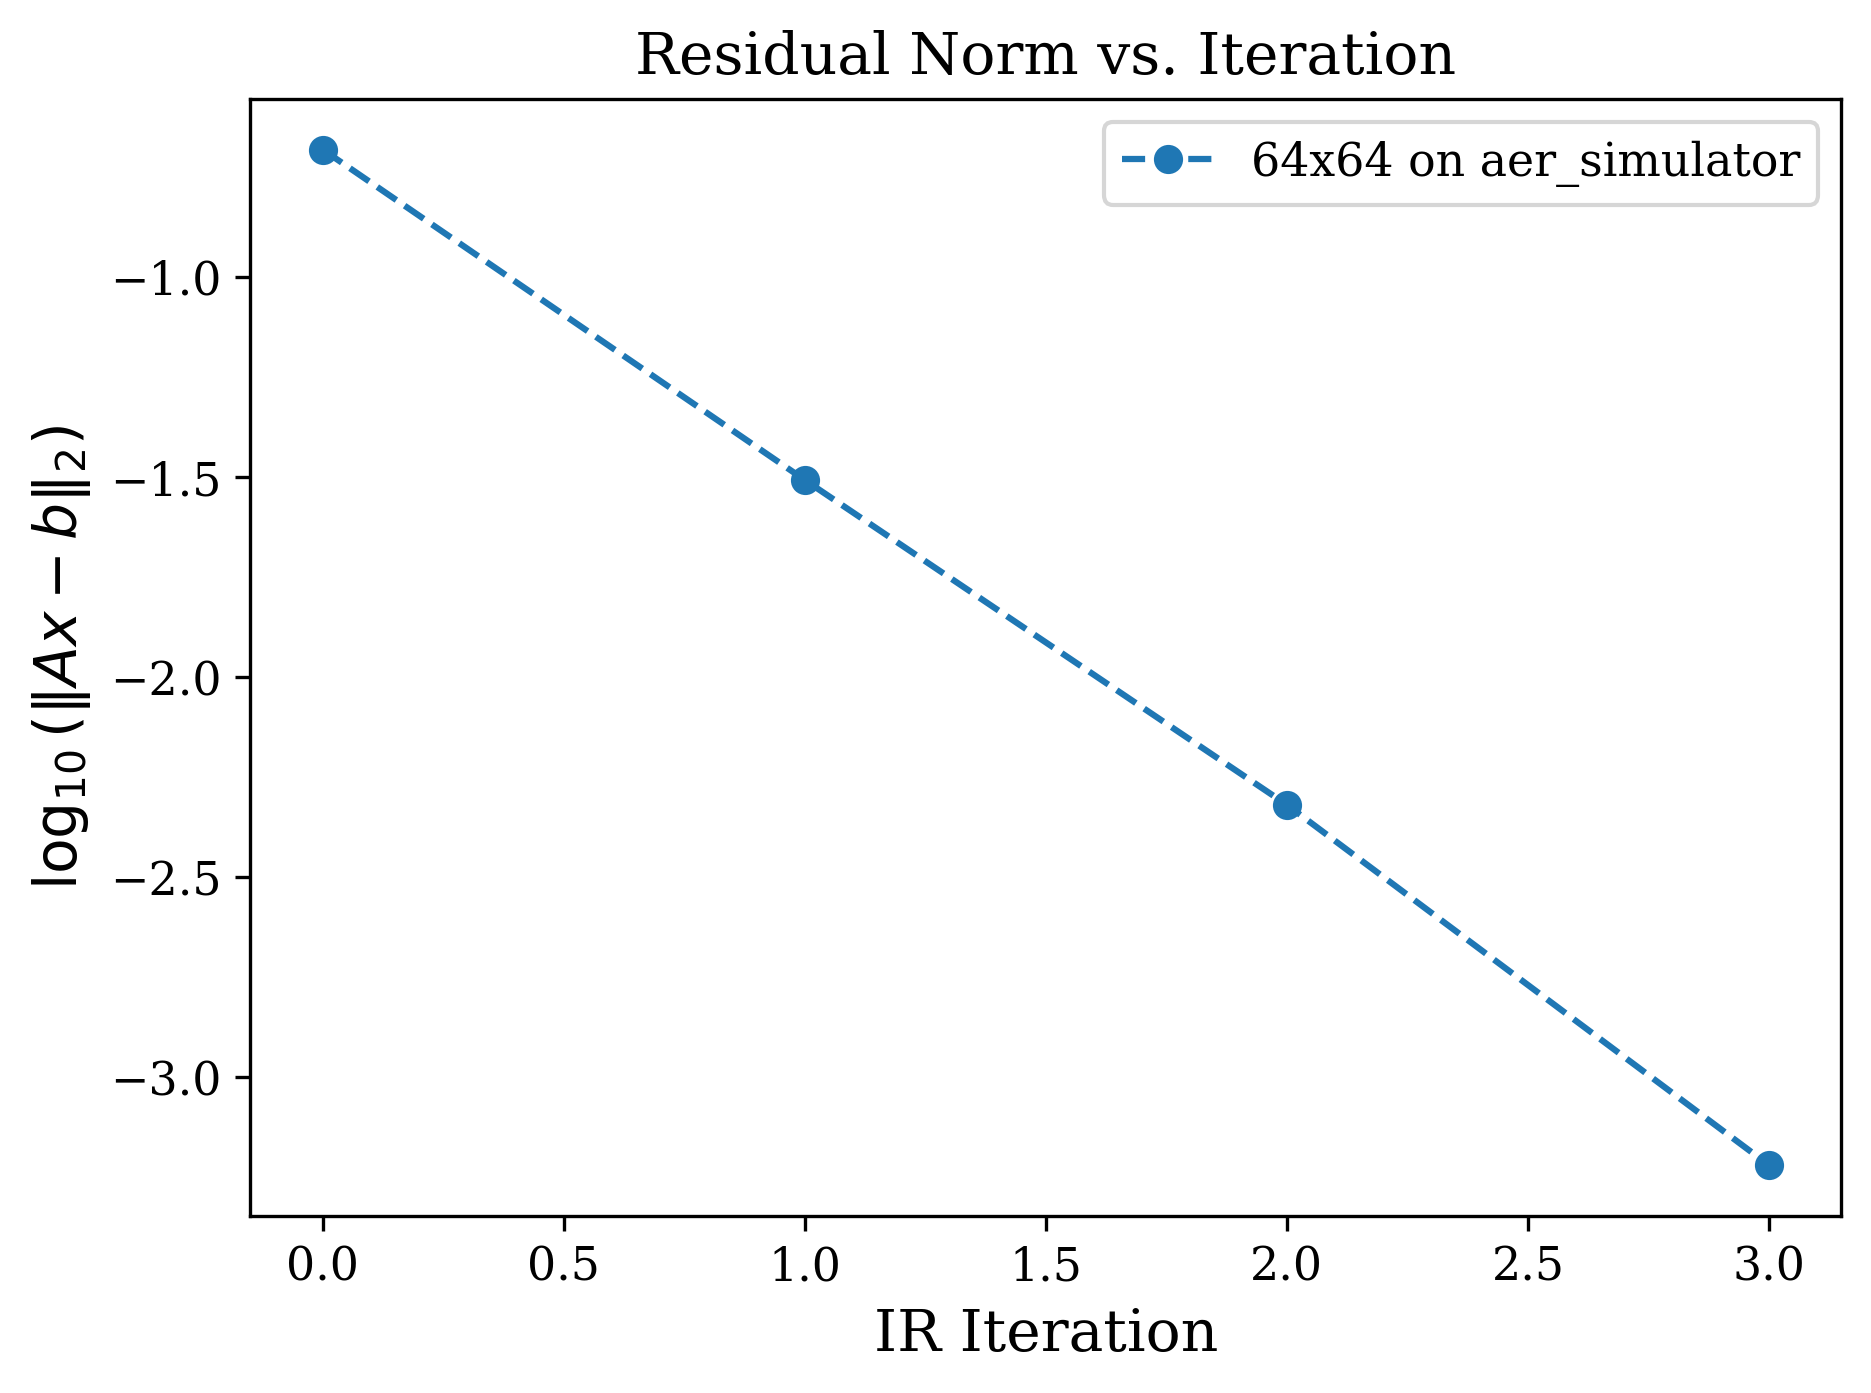

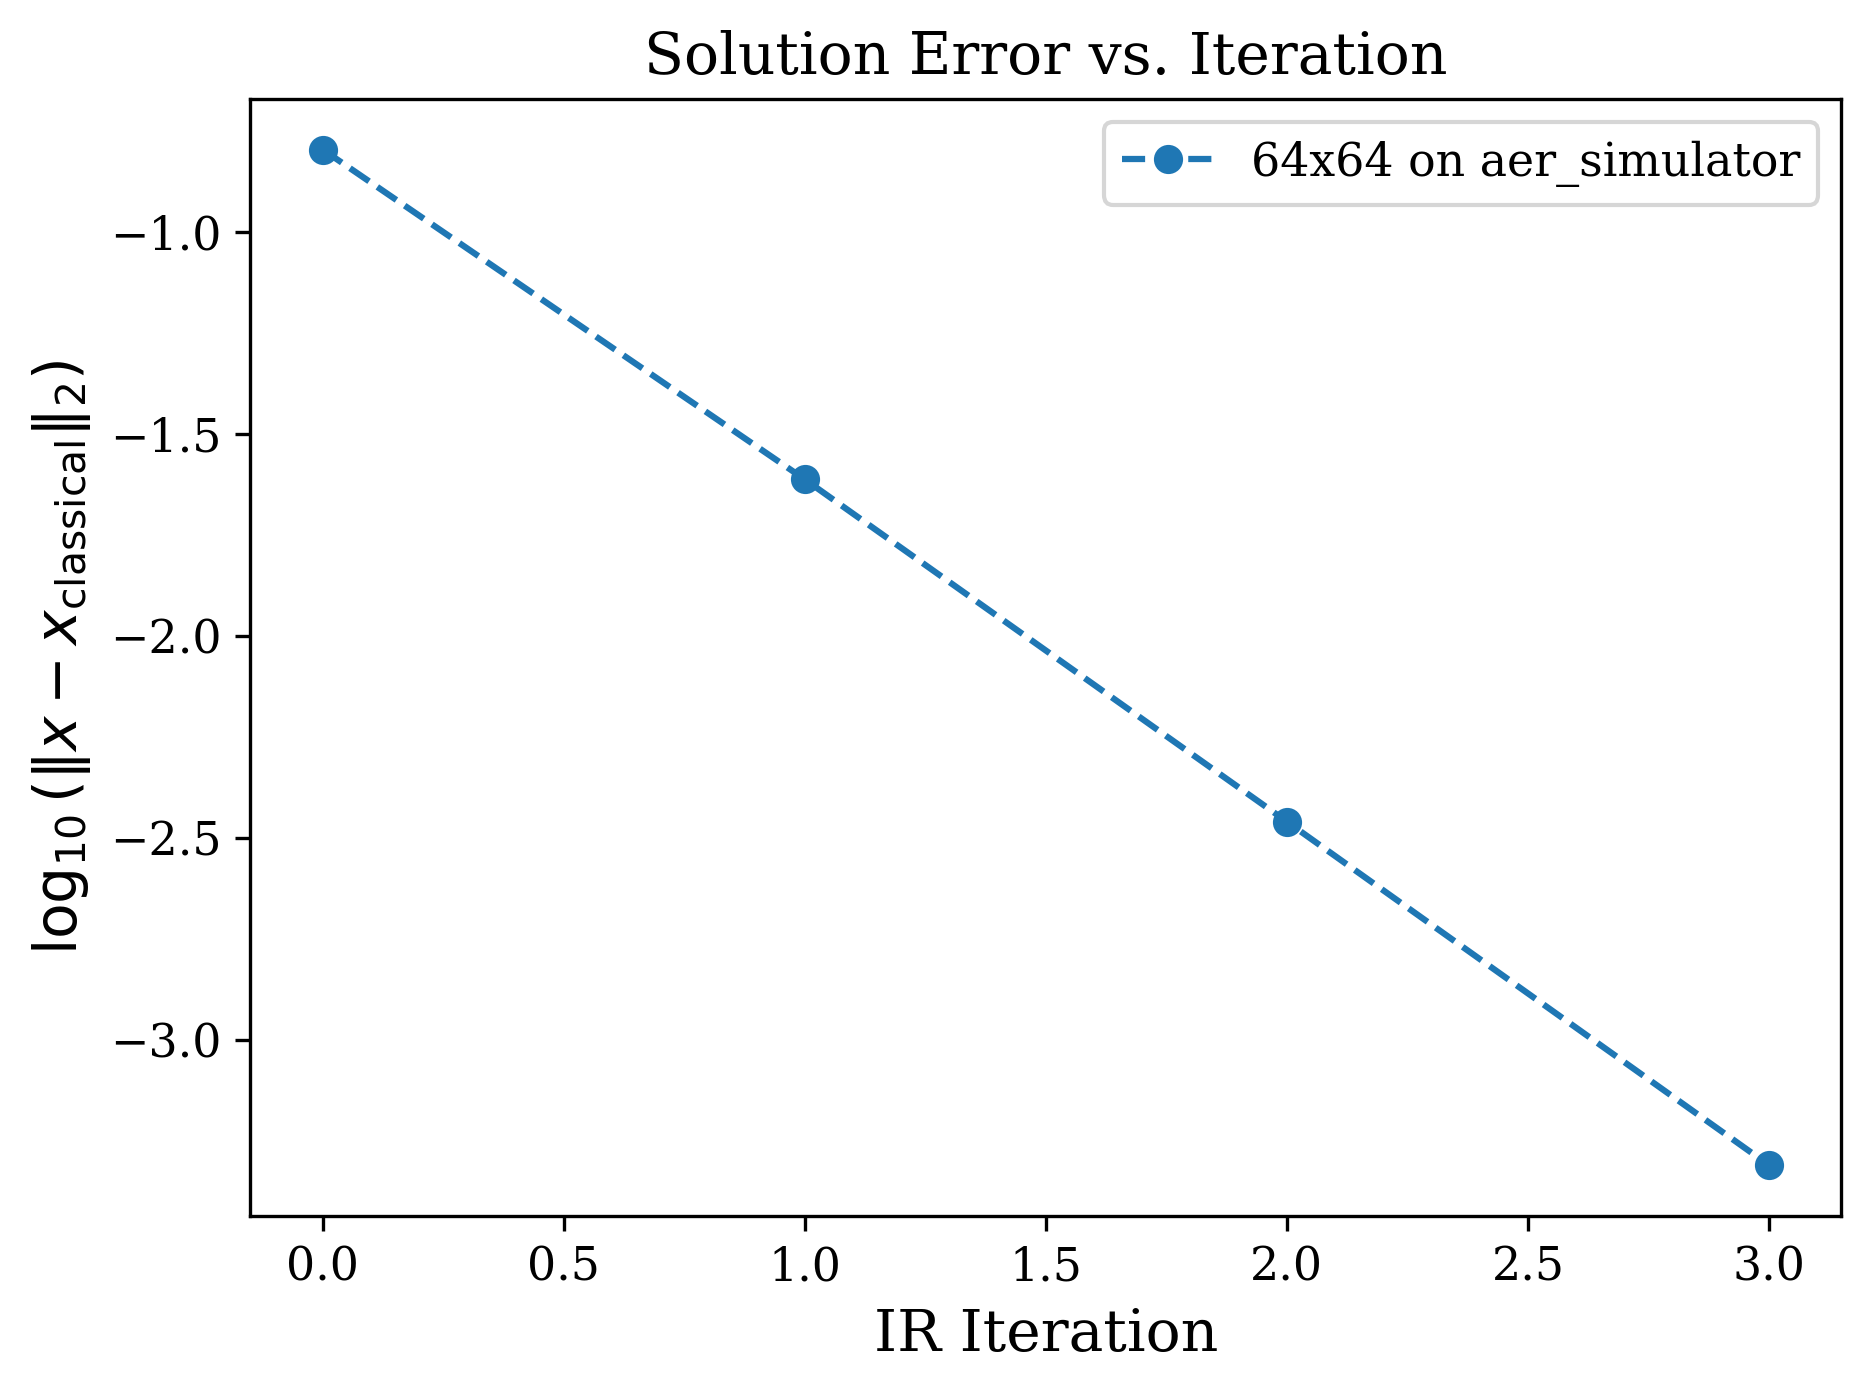

In [18]:
refiner = Refiner(A = A, b = b, solver = hhl_solver)
refined_solution = refiner.refine(precision = 1e-9, max_iter = 3, plot=True)

## Experiments

In [19]:
t0_values = np.linspace(0, 2 * np.pi, 30)
success_rates = []
residual_errors = []

for t0 in t0_values:
    if np.isclose(t0, 0.0):
        # t0=0 causes divide-by-zero in phase-to-eigenvalue mapping
        success_rates.append(np.nan)
        residual_errors.append(np.nan)
        continue

    hhl_circuit = hhl.build_circuit(A, b, t0=t0)
    transpiler = Transpiler(circuit=hhl_circuit, backend=backend, optimization_level=3)
    transpiled_hhl_circuit = transpiler.optimize()

    result = executer.run(
        transpiled_circuit=transpiled_hhl_circuit,
        backend=backend,
        shots=10000,
    )

    solution, success_rate, residual = processor.process_tomography(result, A, b)
    success_rates.append(success_rate)
    residual_errors.append(residual)

>>> Job ID: b1f3c3de-35aa-4dd3-b5d5-ecdd2fac80f0
>>> Job Status: DONE      
total shots: 10000
num_successful_shots: 1704
success rate: 0.1704
solver residual: 0.24060320625073656
>>> Job ID: be233e32-d25c-4de4-9577-b620bd23fe81
>>> Job Status: DONE      
total shots: 10000
num_successful_shots: 1370
success rate: 0.137
solver residual: 0.19143256788721874
>>> Job ID: 8c395b6c-783c-412c-af58-26c610aa767f
>>> Job Status: DONE      
total shots: 10000
num_successful_shots: 1526
success rate: 0.1526
solver residual: 0.1849640754655188
>>> Job ID: 65a9aa5e-3972-4ac8-b0af-93ee135e10f2
>>> Job Status: DONE      
total shots: 10000
num_successful_shots: 1449
success rate: 0.1449
solver residual: 0.17815706590978056
>>> Job ID: 6abb4e84-a013-4487-963d-d2e3c48f5bf3
>>> Job Status: DONE      
total shots: 10000
num_successful_shots: 1303
success rate: 0.1303
solver residual: 0.1686599976097877
>>> Job ID: fb665cc4-9724-43fe-8cbb-d8e2c3a5b1d1
>>> Job Status: DONE      
total shots: 10000
num_succ

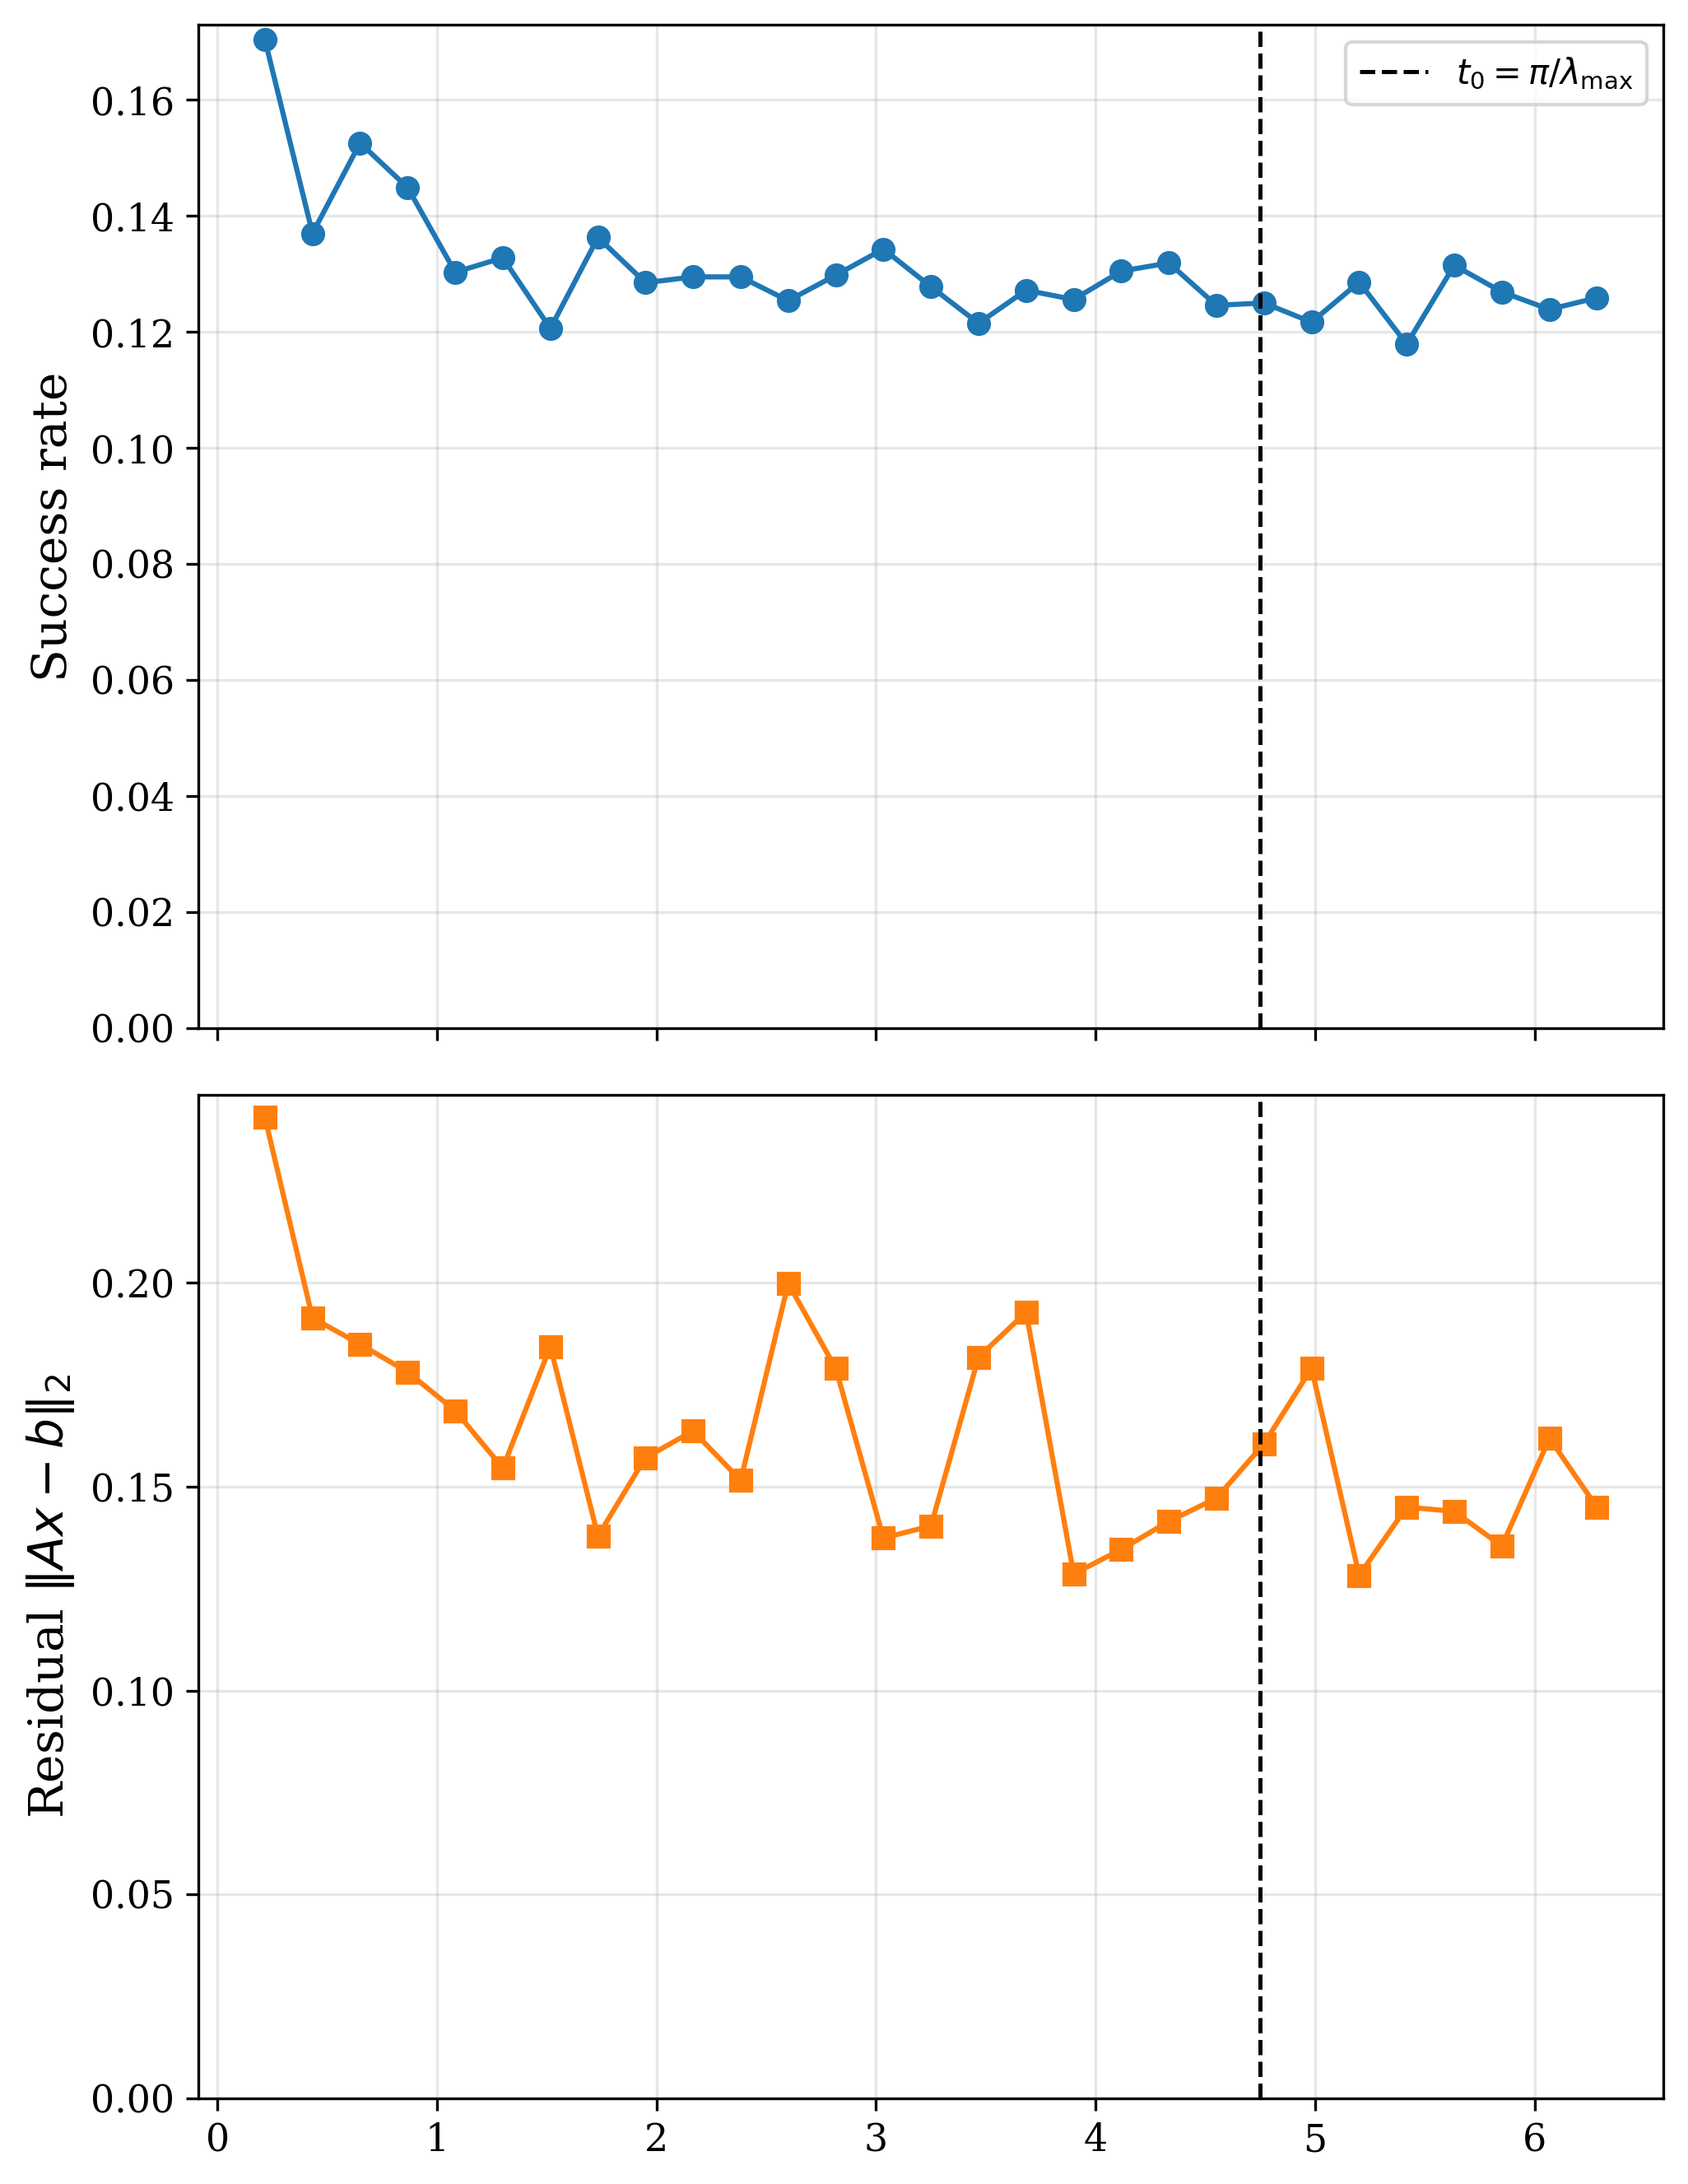

In [20]:
max_lam = np.max(np.abs(np.linalg.eigvalsh(A)))
t0_opt = np.pi / max_lam   # spectral-norm optimal t0

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 9), sharex=True)

# ── Success rate ──────────────────────────────────────────────────────────────
ax1.plot(t0_values, success_rates, marker="o", color="C0", linewidth=1.5)
ax1.axvline(t0_opt, color="black", linestyle="--", linewidth=1.2, label=r"$t_0 = \pi / \lambda_{\max}$")
ax1.set_ylabel("Success rate")
ax1.set_ylim(bottom=0)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# ── Residual error ────────────────────────────────────────────────────────────
ax2.plot(t0_values, residual_errors, marker="s", color="C1", linewidth=1.5)
ax2.axvline(t0_opt, color="black", linestyle="--", linewidth=1.2)
ax2.set_ylabel(r"Residual $\|Ax - b\|_2$")
ax2.set_ylim(bottom=0)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"../data/{n}var_t0_sweep_{backend.name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf")
plt.show()

In [21]:
iterations = 15 #15          # number of IR iterations to plot (0..iterations-1)
max_qpe_qubits = int(math.log2(len(b)) + 1)  # sweep num_qpe_qubits = 1..max_qpe_qubits

# rows: qpe qubits, cols: IR iteration
qpe_residuals = np.full((max_qpe_qubits, iterations), np.nan, dtype=float)
total_circuit_depth = np.full((max_qpe_qubits, iterations), np.nan, dtype=float)

for qpe_qubits in range(1, max_qpe_qubits + 1):
    print(f"================num_qpe_qubits: {qpe_qubits}=================")
    solver = QuantumLinearSolver(
        qlsa=HHL(
            state_prep=StatePrep(method="default"),
            readout="measure_x",
            num_qpe_qubits=qpe_qubits,
            eig_oracle = "classical"
        ),
        backend=AerSimulator(),
        target_successful_shots=1000,
        shots_per_batch=5000,
        optimization_level=3,
        executer=executer,
        post_processor=processor,
    )

    refiner = Refiner(A=A, b=b, solver=solver)
    refined_solution = refiner.refine(precision=1e-20, max_iter=iterations - 1, plot=False)

    r = np.asarray(refined_solution["residuals"], dtype=float)
    qpe_residuals[qpe_qubits - 1, : len(r)] = r

    circuits = refined_solution["transpiled_circuits"]
    depths = np.array([tc.depth() for tc in circuits], dtype=float)
    cumulative_depth = np.cumsum(depths)
    total_circuit_depth[qpe_qubits - 1, : len(cumulative_depth)] = cumulative_depth

# heatmap of log10 residuals
log_qpe_residuals = np.log10(np.maximum(qpe_residuals, 1e-16))
log_total_depth = np.log10(np.maximum(total_circuit_depth, 1))

================num_qpe_qubits: 1=================
IR Iteration: 0
>>> Job ID: 7798a81c-c682-4f66-ba98-74f26c84892e
>>> Job Status: DONE      
  residual: 0.2015, error: 0.2137, alpha: 2.7533

IR Iteration: 1
>>> Job ID: e81954a0-bca5-4d2c-9e40-e2f3db4ac73f
>>> Job Status: DONE      
  residual: 0.0648, error: 0.0515, alpha: 1.1663

IR Iteration: 2
>>> Job ID: adaa81dd-975b-4e0b-b8d3-0fb0e3461845
>>> Job Status: DONE      
  residual: 0.0230, error: 0.0176, alpha: 0.6378

IR Iteration: 3
>>> Job ID: 5e39c054-25de-4193-816e-c5c242203e66
>>> Job Status: DONE      
>>> Job ID: 56331e18-6d02-4a8e-9ee2-43a9dcd38dc6
>>> Job Status: DONE      
  residual: 0.0071, error: 0.0054, alpha: 0.4100

IR Iteration: 4
>>> Job ID: 193d3d5e-e00d-412a-a797-9217602e39b0
>>> Job Status: DONE      
>>> Job ID: 85ebd414-8f69-497e-80df-ad3428490509
>>> Job Status: DONE      
  residual: 0.0021, error: 0.0016, alpha: 0.2678

IR Iteration: 5
>>> Job ID: 3b4bd091-32a2-4daa-b3fb-ae45ec8e8eb9
>>> Job Status: DONE  

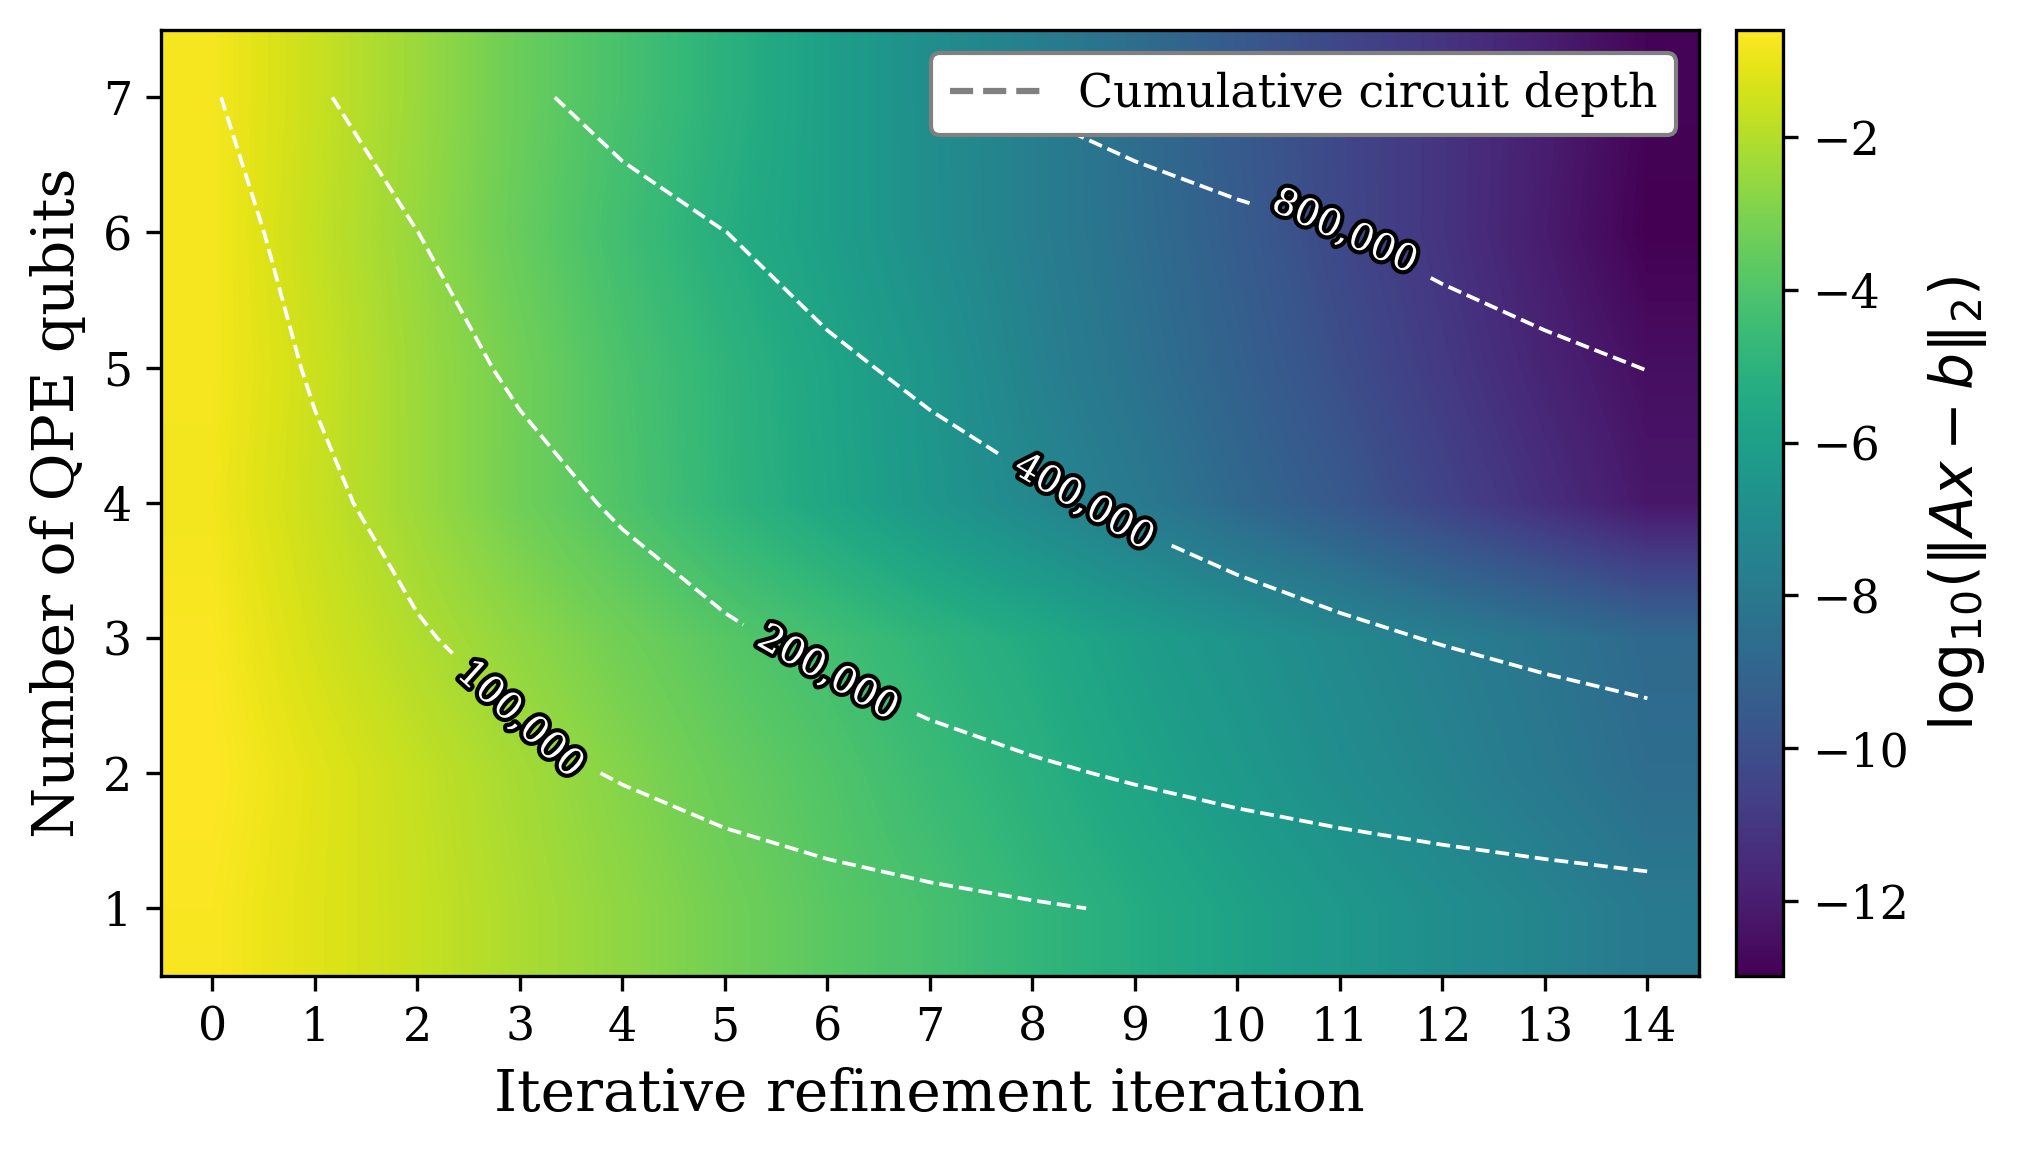

In [30]:
fig, ax = plt.subplots(figsize=(7, 4))
im = ax.imshow(
    log_qpe_residuals,
    origin="lower",
    aspect="auto",
    cmap="viridis",
    interpolation="bilinear",
)

ax.set_xlabel("Iterative refinement iteration")
ax.set_ylabel("Number of QPE qubits")

ax.set_xticks(np.arange(total_circuit_depth.shape[1]))
ax.set_yticks(np.arange(total_circuit_depth.shape[0]))
ax.set_yticklabels(np.arange(1, total_circuit_depth.shape[0] + 1))

cbar = fig.colorbar(im, ax=ax, pad=0.02)
cbar.set_label(r"$\log_{10}\!\left(\|Ax - b\|_2\right)$")
cbar.ax.tick_params(labelsize=11)

X, Y = np.meshgrid(np.arange(total_circuit_depth.shape[1]), np.arange(total_circuit_depth.shape[0]))
cs = ax.contour(X, Y, total_circuit_depth, levels=[100000, 200000, 400000, 800000],
                colors="white", linestyles="--", linewidths=0.9)
labels = ax.clabel(cs, fmt=lambda v: f"{int(v):,}", fontsize=9, colors="white")
outline = [pe.withStroke(linewidth=2, foreground="black")]
for lbl in labels:
    lbl.set_path_effects(outline)

ax.plot([], [], ls="--", color="gray", label="Cumulative circuit depth")
ax.legend(loc="upper right", facecolor="white", framealpha=1.0, edgecolor="gray")

plt.tight_layout()
plt.savefig(f"../data/{n}var_qpe_vs_ir_residuals_with_overlay_{backend.name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf")
plt.show()

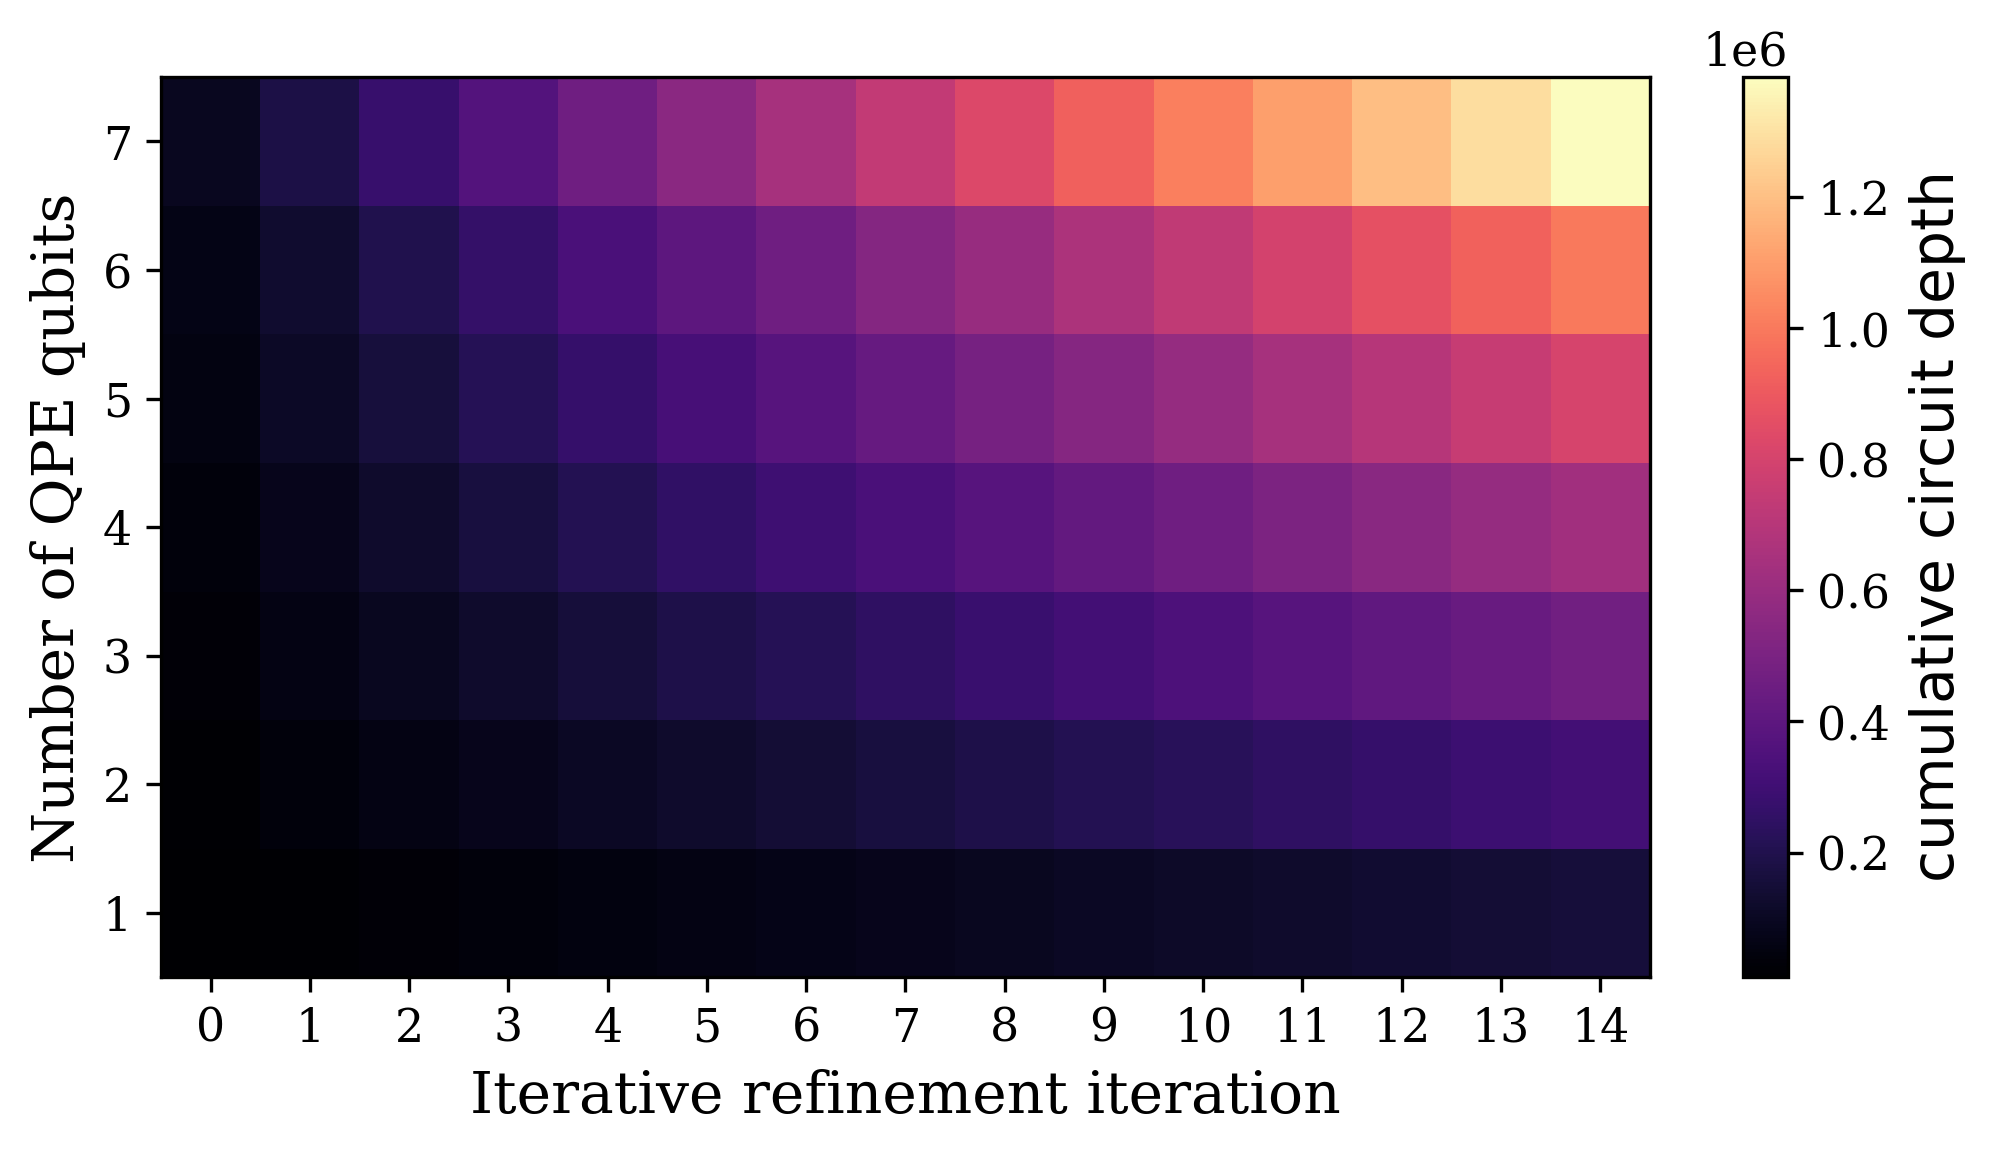

In [23]:
fig, ax = plt.subplots(figsize=(7, 4))
im = ax.imshow(
    total_circuit_depth,
    origin="lower",
    aspect="auto",
    cmap="magma",
    interpolation="nearest",
)

ax.set_xlabel("Iterative refinement iteration")
ax.set_ylabel("Number of QPE qubits")

ax.set_xticks(np.arange(total_circuit_depth.shape[1]))
ax.set_yticks(np.arange(total_circuit_depth.shape[0]))
ax.set_yticklabels(np.arange(1, total_circuit_depth.shape[0] + 1))

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"$\mathrm{cumulative\ circuit\ depth}$")

plt.tight_layout()
plt.show()

In [24]:
iterations = 11 #11          # number of IR iterations to plot (0..iterations-1)
shots = np.linspace(1, 1000, 11, dtype=int)

# rows: shot counts, cols: IR iteration
shot_residuals = np.full((len(shots), iterations), np.nan, dtype=float)


num_qpe_qubits = int(math.log2(len(b)))

for i, shot_count in enumerate(shots):
    print(f"================shots: {shot_count}=================")
    solver = QuantumLinearSolver(
        qlsa=HHL(
            state_prep=StatePrep(method="default"),
            readout="measure_x",
            num_qpe_qubits=num_qpe_qubits,
            eig_oracle = "classical"
        ),
        backend=AerSimulator(),
        target_successful_shots=shot_count,
        shots_per_batch=5 * shot_count,
        optimization_level=3,
        executer=executer,
        post_processor=processor,
    )

    refiner = Refiner(A=A, b=b, solver=solver)
    refined_solution = refiner.refine(precision=1e-20, max_iter=iterations - 1, plot=False)

    r = np.asarray(refined_solution["residuals"], dtype=float)
    shot_residuals[i, : len(r)] = r

# heatmap of log10 residuals
log_shot_residuals = np.log10(np.maximum(shot_residuals, 1e-16))

================shots: 1=================
IR Iteration: 0
>>> Job ID: 00d05801-663a-4044-950e-477450cdaa04
>>> Job Status: DONE      
  residual: 0.9699, error: 1.2117, alpha: 0.7552

IR Iteration: 1
>>> Job ID: 628b0474-098b-43a9-83bc-5a2920efe469
>>> Job Status: DONE      
>>> Job ID: f813d759-bac2-43b0-89a6-54dbd4c2ec89
>>> Job Status: DONE      
  residual: 0.9680, error: 1.2055, alpha: 0.1218

IR Iteration: 2
>>> Job ID: 415b2436-451b-436e-9c0d-9ef69745f6c0
>>> Job Status: DONE      
  residual: 0.9590, error: 1.1468, alpha: 0.4292

IR Iteration: 3
>>> Job ID: ce8cc3a1-1549-48e8-8c44-ca5859001882
>>> Job Status: DONE      
  residual: 0.9450, error: 1.1008, alpha: 0.6792

IR Iteration: 4
>>> Job ID: 1ce03b69-a1ec-4edf-81ab-dbe533d8e949
>>> Job Status: DONE      
  residual: 0.9250, error: 1.0623, alpha: 0.5860

IR Iteration: 5
>>> Job ID: 135d925e-27b6-42a9-bb6f-98057760f378
>>> Job Status: DONE      
>>> Job ID: 22bd8d7e-3509-452d-91cf-44ec237bee40
>>> Job Status: DONE      
  re

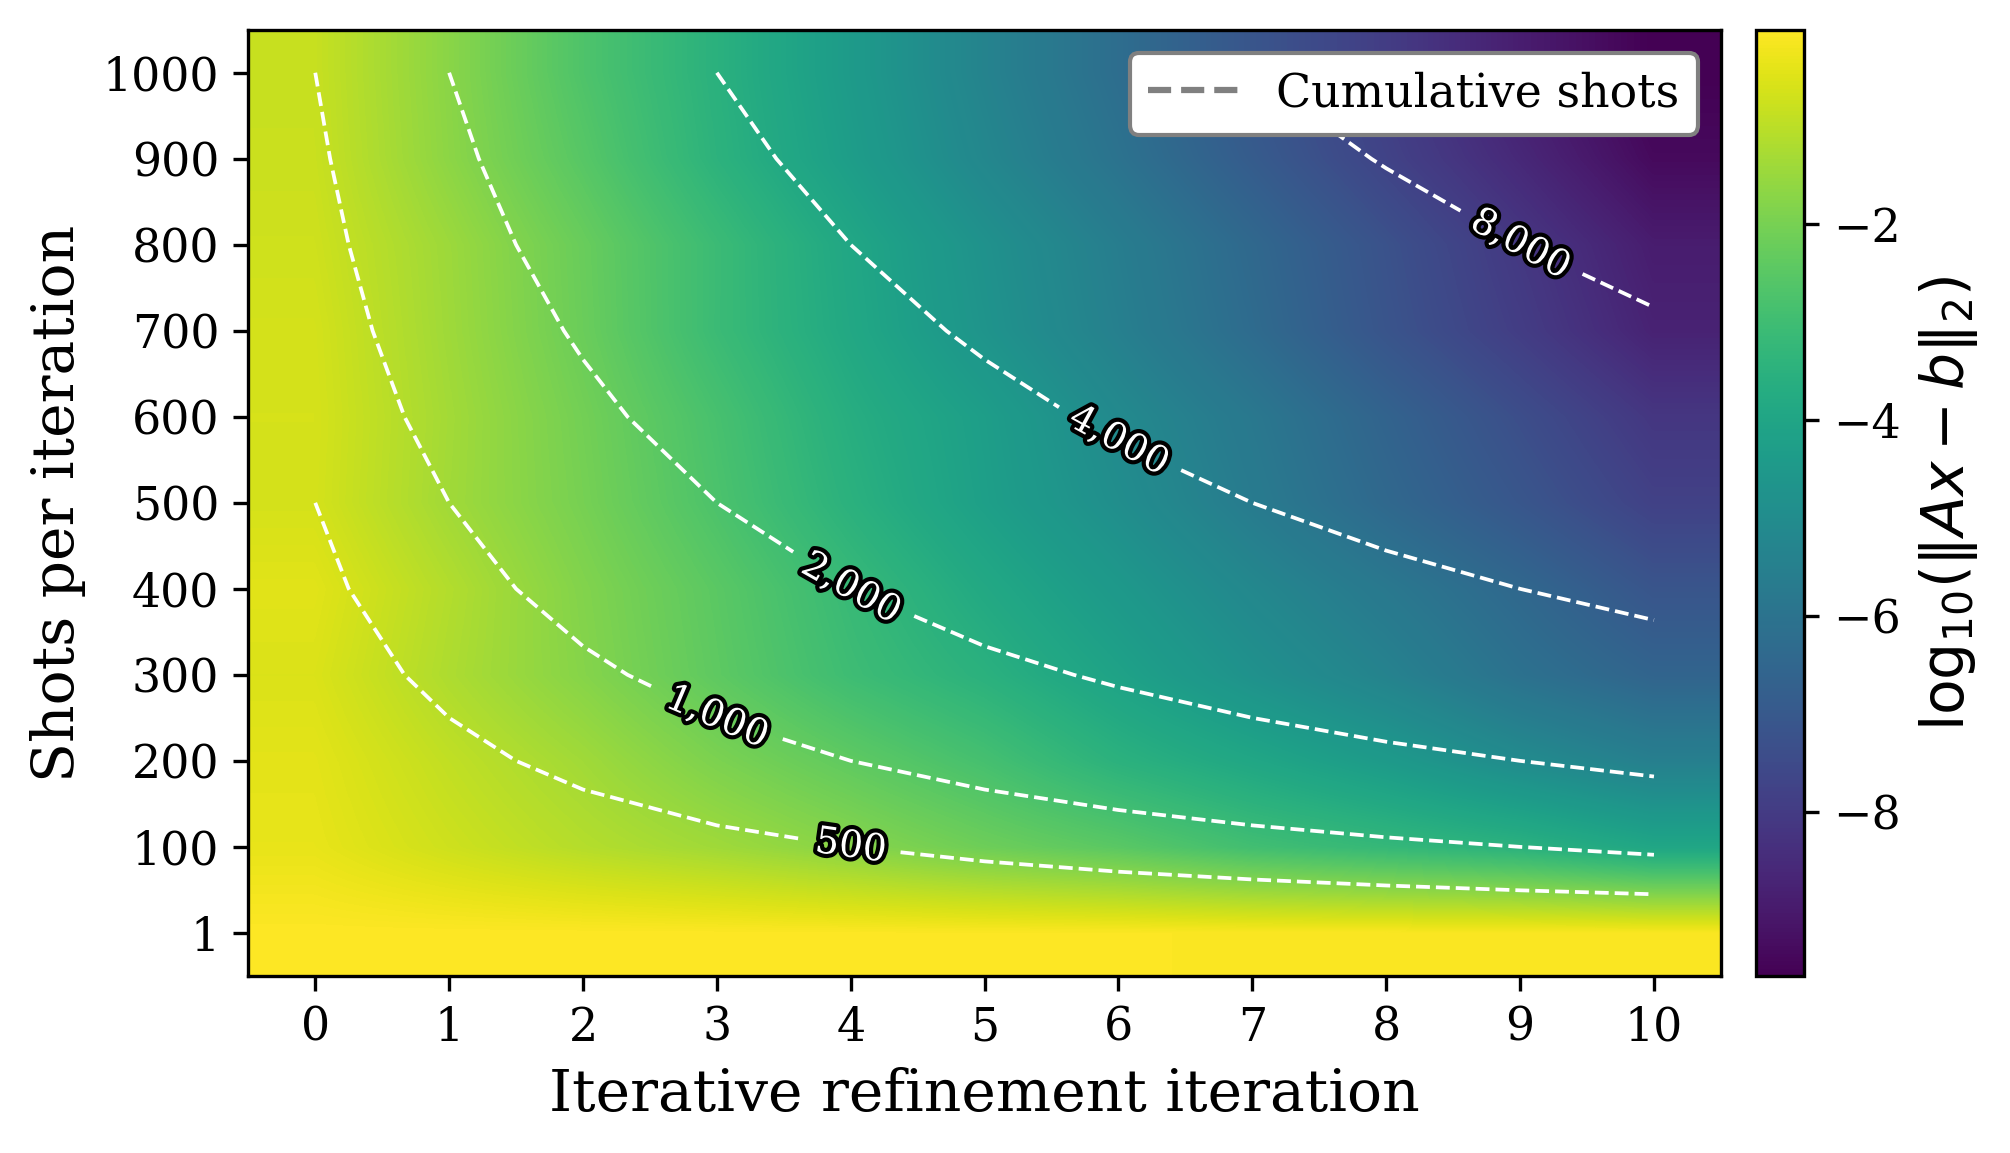

In [32]:
fig, ax = plt.subplots(figsize=(7, 4))
im = ax.imshow(
    log_shot_residuals,
    origin="lower",
    aspect="auto",
    cmap="viridis",
    interpolation="bilinear",
)

ax.set_xlabel("Iterative refinement iteration")
ax.set_ylabel("Shots per iteration")

ax.set_xticks(np.arange(iterations))
ax.set_yticks(np.arange(len(shots)))
ax.set_yticklabels(shots)

cbar = fig.colorbar(im, ax=ax, pad=0.02)
cbar.set_label(r"$\log_{10}\!\left(\|Ax - b\|_2\right)$")
cbar.ax.tick_params(labelsize=11)

X, Y = np.meshgrid(np.arange(iterations), np.arange(len(shots)))
cumulative_shots = shots[:, None] * (X + 1)
levels = [500, 1000, 2000, 4000, 8000]
cs = ax.contour(X, Y, cumulative_shots, levels=levels,
                colors="white", linestyles="--", linewidths=0.9)
labels = ax.clabel(cs, fmt=lambda v: f"{int(v):,}", fontsize=9, colors="white")
outline = [pe.withStroke(linewidth=2, foreground="black")]
for lbl in labels:
    lbl.set_path_effects(outline)

ax.plot([], [], ls="--", color="gray", label="Cumulative shots")
ax.legend(loc="upper right", facecolor="white", framealpha=1.0, edgecolor="gray")

plt.tight_layout()
plt.savefig(f"../data/{n}var_shots_vs_ir_residuals_with_overlay_{backend.name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf")
plt.show()

In [26]:
# n = 64
# max_qpe_qubits = 6
# shot_values = np.linspace(1, 200, 21, dtype=int)

# single_solve_residuals = np.full((max_qpe_qubits, len(shot_values)), np.nan, dtype=float)

# prob = generate_problem(n=n, cond_number=5.0, sparsity=0.5, seed=0)
# A, b = prob["A"], prob["b"]
# A = A / np.linalg.norm(b)
# b = b / np.linalg.norm(b)
# x_classical = np.linalg.solve(A, b)

# for qi, qpe_qubits in enumerate(range(1, max_qpe_qubits + 1)):
#     for si, shot_count in enumerate(shot_values):
#         print(f"qpe={qpe_qubits}, shots={shot_count}")
#         solver = QuantumLinearSolver(
#             qlsa=HHL(
#                 state_prep=StatePrep(method="default"),
#                 readout="measure_x",
#                 num_qpe_qubits=qpe_qubits,
#                 t0=2 * np.pi,
#             ),
#             backend=AerSimulator(),
#             target_successful_shots=int(shot_count),
#             shots_per_batch=5 * int(shot_count),
#             optimization_level=3,
#             executer=executer,
#             post_processor=processor,
#         )
#         x_q = solver.solve(A, b, verbose=False)
#         alpha = np.dot(A @ x_q, b) / np.dot(A @ x_q, A @ x_q)
#         x_scaled = alpha * x_q
#         single_solve_residuals[qi, si] = np.linalg.norm(b - A @ x_scaled)

# log_single_residuals = np.log10(np.maximum(single_solve_residuals, 1e-16))

In [27]:
# fig, ax = plt.subplots(figsize=(7, 4))
# im = ax.imshow(
#     single_solve_residuals,
#     origin="lower",
#     aspect="auto",
#     cmap="viridis",
#     interpolation="nearest",
# )

# ax.set_xlabel("Shots")
# ax.set_ylabel("Number of QPE qubits")

# ax.set_xticks(np.arange(len(shot_values)))
# ax.set_xticklabels(shot_values, rotation=45, ha="right")
# ax.set_yticks(np.arange(max_qpe_qubits))
# ax.set_yticklabels(np.arange(1, max_qpe_qubits + 1))

# cbar = fig.colorbar(im, ax=ax, pad=0.02)
# cbar.set_label(r"$\log_{10}\!\left(\|Ax - b\|_2\right)$")
# cbar.ax.tick_params(labelsize=11)

# plt.tight_layout()
# # plt.savefig("qpe_vs_shots_residuals.pdf")
# plt.show()

In [28]:
# from matplotlib.colors import ListedColormap

# converges = single_solve_residuals < 1

# cmap_rg = ListedColormap(["#d62728", "#2ca02c"])

# fig, ax = plt.subplots(figsize=(7, 4))
# im = ax.imshow(
#     converges.astype(int),
#     origin="lower",
#     aspect="auto",
#     cmap=cmap_rg,
#     interpolation="nearest",
#     vmin=0,
#     vmax=1,
# )

# ax.set_xlabel("Shots")
# ax.set_ylabel("Number of QPE qubits")

# ax.set_xticks(np.arange(len(shot_values)))
# ax.set_xticklabels(shot_values, rotation=45, ha="right")
# ax.set_yticks(np.arange(max_qpe_qubits))
# ax.set_yticklabels(np.arange(1, max_qpe_qubits + 1))

# from matplotlib.patches import Patch
# legend_handles = [
#     Patch(facecolor="#2ca02c", edgecolor="gray", label=r"$\|r\| < 1$ (IR will converge)"),
#     Patch(facecolor="#d62728", edgecolor="gray", label=r"$\|r\| \geq 1$ (IR will not converge)"),
# ]
# ax.legend(handles=legend_handles, loc="upper left", facecolor="white", framealpha=1.0, edgecolor="gray")

# plt.tight_layout()
# # plt.savefig("qpe_vs_shots_convergence.pdf")
# plt.show()